In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import os
import sys
from scipy import stats

from src.utils.Cleaning import GetCleanedData

# Data cleaning

### 1st dataset
After some data exploration we decided to clean the data. 
- Rows with missing Movie country, languages or genres were dropped
- Only the year of the movie release date was kept
- Only the first genre of a movie was kept

We saw that when we clean the rows that do not contain values of box office revenue the dataset is seriously reduced. Our idea was to keep a version of the dataset without taking care of the box office revenue when it is not the target of the analysis. We notice that the size difference between  df_date_revenue_clean and df_date_revenue_runtime_clean is negligeable, no need to treat them separately.

In [2]:
# Importing data
initial_directory = os.getcwd()
os.chdir(initial_directory)
PATH = 'data'
header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 
          'Movie languages', 'Movie country', 'Movie genres']
df = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', names=header, skipinitialspace=True)

In [3]:
print("Data set initial size = ", df.size)
print("Number of NaN values for each columns:")
if df.isnull().values.any():
    print(df.isnull().sum())

Data set initial size =  735669
Number of NaN values for each columns:
Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie country                   0
Movie genres                    0
dtype: int64


In [4]:
df_date_clean, df_date_revenue_clean, df_date_revenue_runtime_clean = GetCleanedData(df)

print('Size of the data with the dates cleaned up : ', df_date_clean.size)
print('Size of the data with the dates and the box office revenues cleaned up : ', df_date_revenue_clean.size)
print('Size of the data with the dates, the box office revenues and the runtimes cleaned up : ', df_date_revenue_runtime_clean.size)

Size of the data with the dates cleaned up :  555498
Size of the data with the dates and the box office revenues cleaned up :  72198
Size of the data with the dates, the box office revenues and the runtimes cleaned up :  71829


In [5]:
# Storage of clean df in data folder

DATA_PATH = 'data'
os.makedirs(DATA_PATH, exist_ok=True)  # Creation of data folder if it does not exist

df_date_clean.to_csv(DATA_PATH + '/df_date_clean.csv', index=False)
df_date_revenue_clean.to_csv(DATA_PATH + '/df_date_revenue_clean.csv', index=False)
df_date_revenue_runtime_clean.to_csv(DATA_PATH + '/df_date_revenue_runtime_clean.csv', index=False)


In [6]:
df_date_revenue_runtime_clean.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
10527,35342638,/m/0j9nzpm,La Leyenda de la Llorona,2011,3898653.0,81.0,[Spanish Language],Mexico,Comedy film
68711,22374348,/m/05sxh20,Séraphine,2008,9147877.0,121.0,"[French Language, Latin Language, German Langu...",France,Period piece
43714,552592,/m/02p775,The Mighty Ducks,1992,50752337.0,100.0,[English Language],United States of America,Sports
76763,2310527,/m/072vmw,The Specials,2000,13276.0,82.0,[English Language],United States of America,Parody
54643,27361432,/m/0bx_mhf,The Redhead and the Cowboy,1951,1250000.0,82.0,[English Language],United States of America,Action/Adventure


### 2nd dataset

No particular cleaning.


In [7]:
header2 = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender',
           'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase character map']
df2 = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', index_col=False, names=header2, skipinitialspace=True, usecols=range(len(header2)))

In [8]:
df2.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [9]:
if df2.isnull().values.any():
    print(df2.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie release date              9995
Character Name                257875
Actor DOB                     106145
Actor gender                   45609
Actor height                  295845
Actor ethnicity               344611
Actor name                      1228
Actor age at movie release    158113
Freebase character map             0
dtype: int64


### Merged dataset

We decided to merge both dataset into one dataframe. 

We previously cleaned both dataframe as needed so no further cleaning in this step, just merging and checking everything is as expected.

In [10]:
merged_df = pd.merge(df_date_clean, df2, on='Wikipedia movie ID', how='inner')

merged_df = merged_df.drop(columns=['Freebase movie ID_y', 'Movie release date_y'])

merged_df = merged_df.rename(columns={'Freebase movie ID_x': 'Freebase movie ID', 
                                      'Movie release date_x': 'Movie release date'})


In [11]:
if merged_df.isnull().values.any():
    print(merged_df.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie name                         0
Movie release date                 0
Movie box office revenue      304688
Movie runtime                  34286
Movie languages                    0
Movie country                      0
Movie genres                       0
Character Name                220899
Actor DOB                      97401
Actor gender                   41620
Actor height                  264350
Actor ethnicity               309417
Actor name                      1100
Actor age at movie release    135626
Freebase character map             0
dtype: int64


In [12]:
# Check if there is duplicated row after the merge

merged_df_str = merged_df.applymap(lambda x: str(x) if isinstance(x, list) else x)
duplicate_count = merged_df_str.duplicated().sum()

print("Number of duplicated rows:", duplicate_count)

Number of duplicated rows: 0


In [13]:
# Check bound of date for the merged_df

min_date = merged_df['Movie release date'].min()
max_date = merged_df['Movie release date'].max()

print("Minimum date of merged_df : ", min_date)
print("Maximum fate of merged_df : ", max_date)

Minimum date of merged_df :  1888
Maximum fate of merged_df :  2015


In [14]:
merged_df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [15]:
merged_df.to_csv(DATA_PATH + '/merged_df.csv', index=False)

### GDP dataset

We created this dataset of GDP specifically for our project, so it is already tailored to our requirements and does not require any additional cleaning.

In [16]:
df_gdp = pd.read_csv(PATH + '/GDP.csv', sep=';',)
df_gdp = df_gdp.rename(columns={"Country": "Movie country"})

In [17]:
# Save in data folder
df_gdp.to_csv(DATA_PATH + '/df_gdp.csv', index=False)

# Data Analysis

### 1) Dataset Exploration

In [18]:
df_date_clean.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime
count,6.172200e+04,8.022000e+03,5.088300e+04
mean,1.539422e+07,4.964957e+07,1.161860e+02
std,1.067139e+07,1.141114e+08,4.784624e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,5.698308e+06,2.248500e+06,8.300000e+01
50%,1.399151e+07,1.144700e+07,9.400000e+01
75%,2.405099e+07,4.304377e+07,1.070000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In the first part of this analysis, we focus on the first 18 countries which produce the more movies

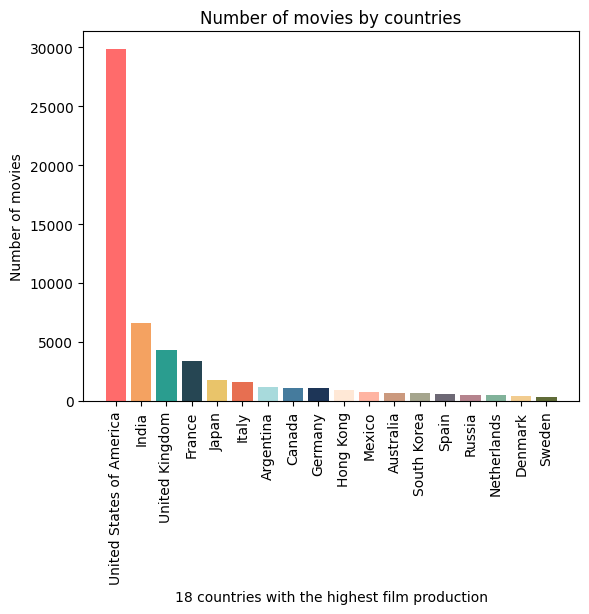

In [19]:
countries = df_date_clean.groupby(['Movie country']).count()['Wikipedia movie ID']

countries['Russia'] = countries['Russia'] + countries['Soviet Union']
countries['Germany'] = countries['Germany'] + countries['German Democratic Republic'] + countries['West Germany']
countries = countries.drop('Soviet Union')
countries = countries.nlargest(18)
countries_names = countries.index.to_list()

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]


plt.bar(countries_names,countries,width=0.8, color = colors)
plt.xticks(rotation=90)
plt.xlabel('18 countries with the highest film production')
plt.ylabel('Number of movies')
plt.title('Number of movies by countries')
plt.show()

This barplot shows the main global movies producer is the USA. Their industry is really developped compared to the rest of the world. There are producing at least 4 times more movies than the second biggest producer which is India.

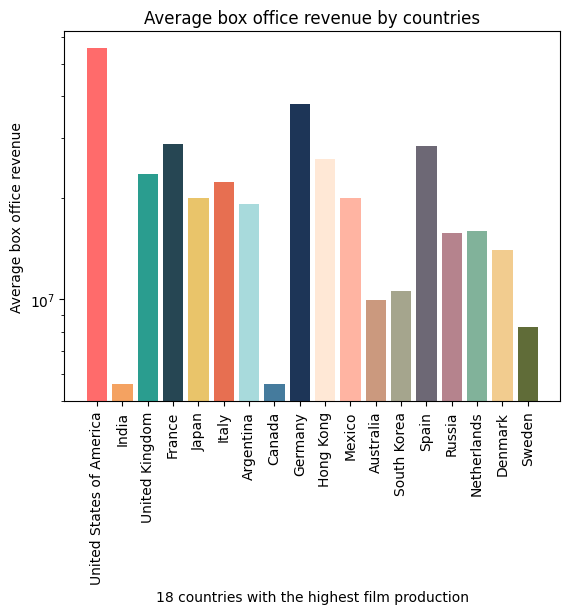

In [20]:
countries_revenues = df_date_revenue_clean.groupby(['Movie country'])['Movie box office revenue'].mean()
countries_revenues['Germany'] = (countries_revenues['Germany'] + countries_revenues['West Germany'])/2
countries_revenues = countries_revenues.drop('West Germany')
countries_revenues = countries_revenues[countries_names]

plt.bar(countries_names, countries_revenues, color = colors)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('18 countries with the highest film production')
plt.ylabel('Average box office revenue')
plt.title('Average box office revenue by countries')
plt.show()

This dsitribution is in log scale because the values of box office revenues are extremely different depending on the different countries
This distribution is very different than the previous one. It tells us that the contries that produce the more movies are not ones making the more money with this industry. For example, India is the second producer but is also the country that makes the least money for each film compared to the 18 biggest producers in the world. The wealthiest countries are the countries with the highest box offices per movie independantely of the level of production.

In this section, we will focus on the 6 diverse film producers (USA, India, UK, Japan, Argentina and Iran) and analyse their movie production over the years, starting from 1890 to 2016.

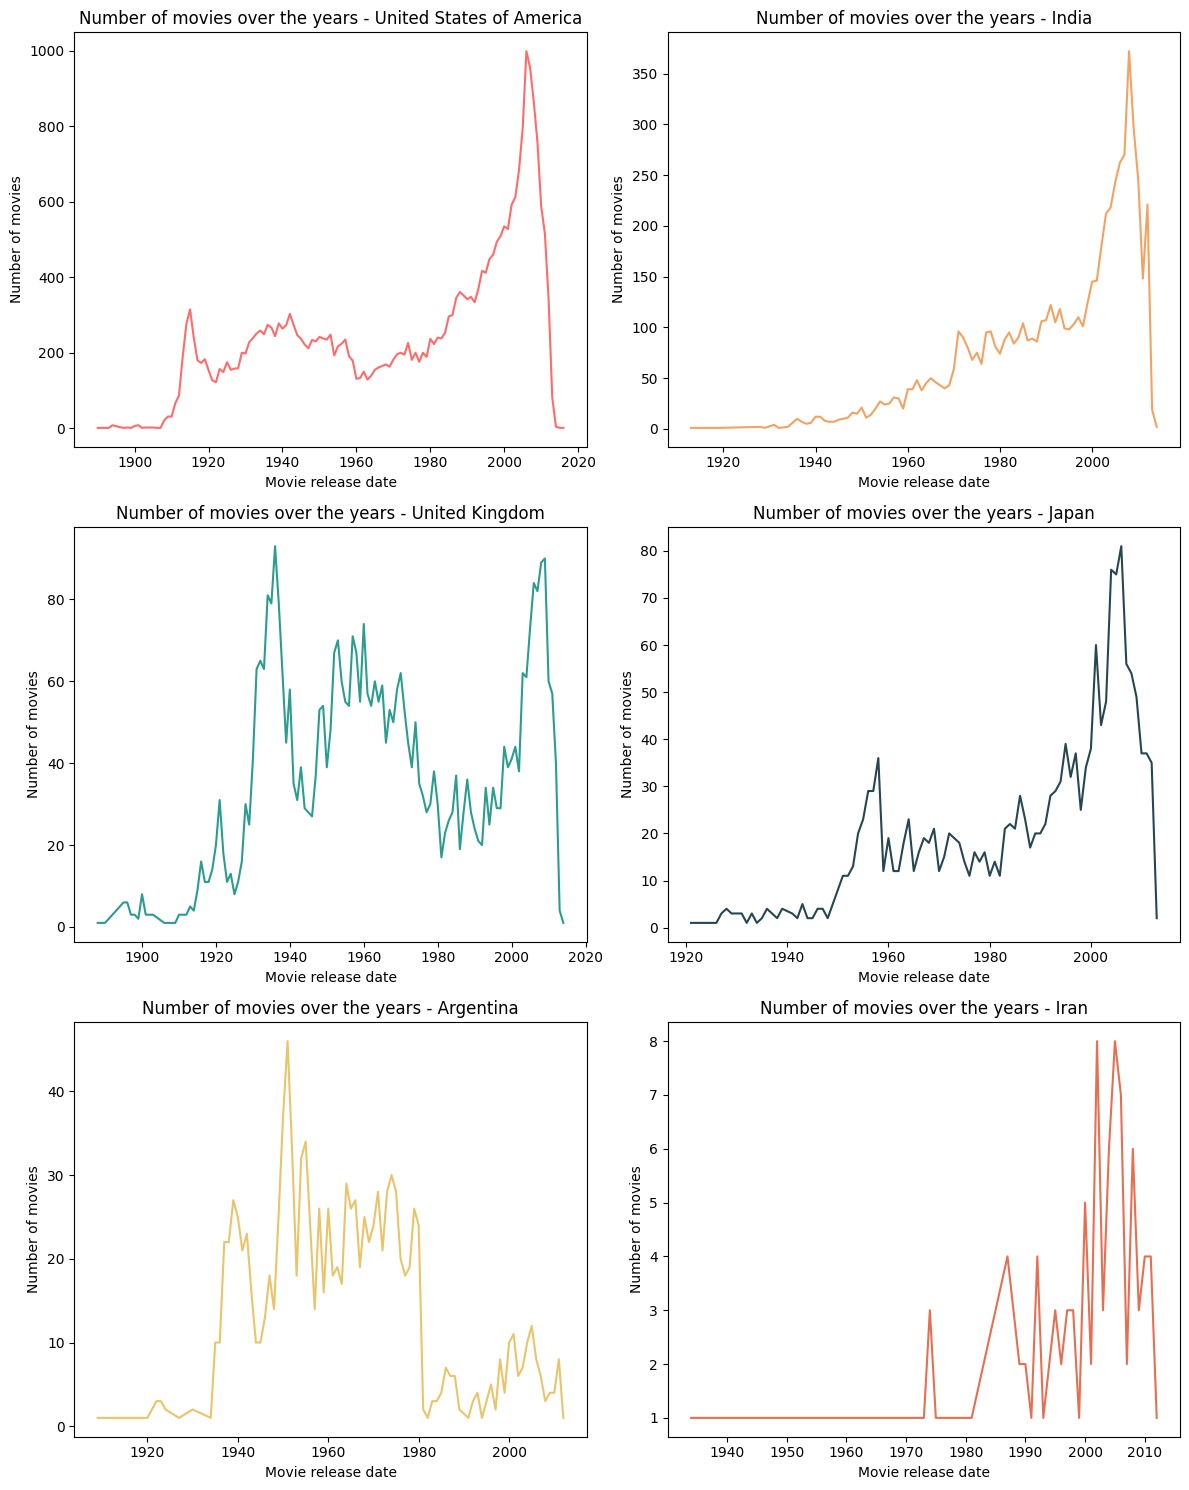

In [21]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']
color_dict = dict(zip(focus_countries, colors))

df_focus = df_date_clean[df_date_clean['Movie country'].isin(focus_countries)]

nb_per_year = df_focus.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})

nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()


for idx, country in enumerate(focus_countries):
    country_data = nb_per_year[nb_per_year['Movie country'] == country]
    axes[idx].plot(country_data['Movie release date'], country_data['Movie count'], linestyle='-', color=color_dict[country])
    axes[idx].set_title(f"Number of movies over the years - {country}")
    axes[idx].set_xlabel("Movie release date")
    axes[idx].set_ylabel("Number of movies")

plt.tight_layout()
plt.show()

The global trend that we see on the 6 graphs is an increase of the movie production between 1890 and 2007. We can interprate those result and estimate that the advancement of new technologies worldwide are the major cause of this increase.

We can observe a drop in the american movie production around 1915 which coincides with World War I. It did not really affected the UK because their movie production was very low at that time. India, Argentina, Iran and Japan was not involved in World War I. Concerning World War II the observation is a bit different. We notice a huge decrease of number of movie for the UK and Argentina around 1939-1945 and a less important one for the USA. UK and USA were directly involved in the World War II while Argentina had the influence of Germany and Italy. Moreover, the number of movies produced per yer before 1940 for Japan is very low but we can observe that this number increases a lot after World War II. 

Around 2007, we discern a fall of prodcution for the 6 countries. This date corresponds to the appearance of Netflix, a platform that offers a streaming service of movies, series. People can access to huge number of movies very easily without having to go to cinema theatres. 2008 economic crisis could also have an impact on this production of movies.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


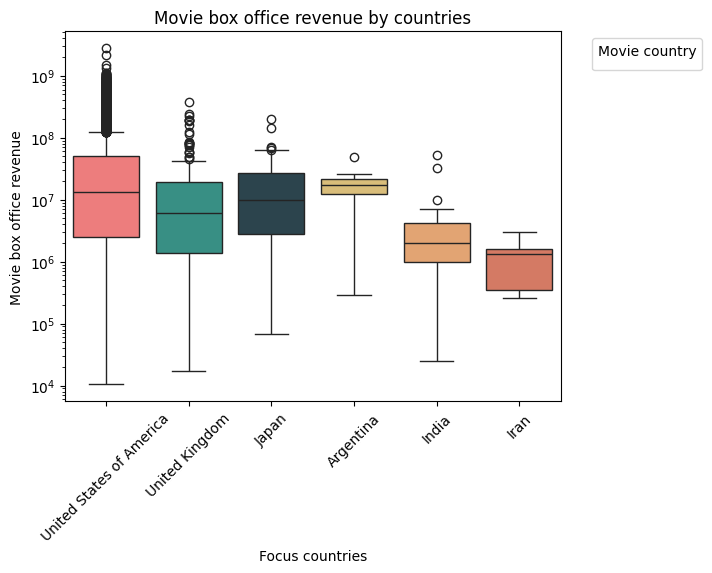

In [22]:
df_revenue_focus = df_date_revenue_clean[df_date_revenue_clean['Movie country'].isin(focus_countries)]

countries_revenues = df_revenue_focus.groupby(['Movie country'])['Movie box office revenue']

sns.boxplot(x='Movie country', y='Movie box office revenue', hue='Movie country', data=df_revenue_focus, palette=color_dict, dodge=False)

plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Focus countries')
plt.ylabel('Movie box office revenue')
plt.title('Movie box office revenue by countries')
plt.legend(title='Movie country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

India is the second country with the highest number of films produced however the boxplot shows that the movie box office revenue per film is lower than UK, Japan or Argentina even if these countries produce less films. 

USA is still the first country and there are a lot of outliers with a high movie box office revenue. 

Argentina is the 7 country with the highest nb of films produced, after USA, India, UK and Japan. However, we can observe that in mean, it has a highest movie box office revenue per film than these countries. It also has a lower difference between first and third quartile. However it has just one outliers with a abnormaly high movie box office revenue. 

Iran is the country with the lowest number of film produced and also, in average, the lowest movie box office revenue. Nonetheless, it has the lowest gap between whiskers meaning that the distribution of the box office revenue per film is consistent.

# Correlation

In this part, we explore the correlation between GDP and movie industry.

<Axes: xlabel='Movie Count Range', ylabel='Revenue Range'>

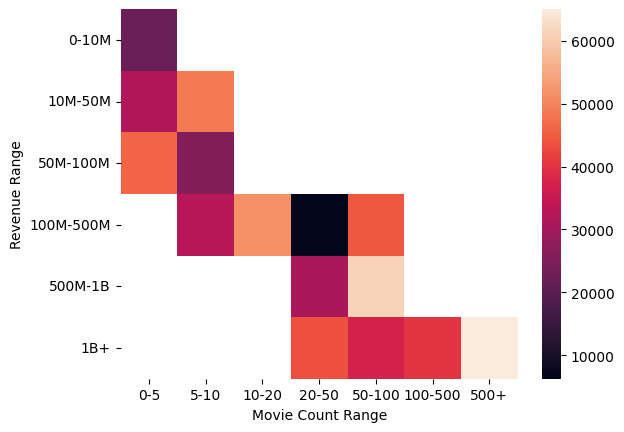

In [23]:
# HEATMAP 

# Preparation of data for the heatmap
nb_per_year = df_date_revenue_clean.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})
nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

total_films_per_country = nb_per_year.groupby('Movie country')['Movie count'].sum().reset_index()
total_films_per_country.columns = ['Movie country', 'Total Movie Count']
df_correlation = pd.merge(df_gdp,total_films_per_country, on='Movie country')

total_revenue_per_country = df_date_revenue_clean.groupby('Movie country')['Movie box office revenue'].sum().reset_index()
total_revenue_per_country.columns = ['Movie country', 'Total Box office revenue']

df_correlation = pd.merge(df_correlation, total_revenue_per_country, on='Movie country')

# Creation of range for the heatmap
df_correlation['Revenue Range'] = pd.cut(df_correlation['Total Box office revenue'], 
                                         bins=[0, 1e7, 5e7, 1e8, 5e8, 1e9, df_correlation['Total Box office revenue'].max()],
                                         labels=['0-10M', '10M-50M', '50M-100M', '100M-500M', '500M-1B', '1B+'])
df_correlation['Movie Count Range'] = pd.cut(df_correlation['Total Movie Count'], 
                                             bins=[0, 5, 10, 20, 50, 100, 500, df_correlation['Total Movie Count'].max()],
                                             labels=['0-5', '5-10', '10-20', '20-50', '50-100', '100-500', '500+'])

df3 = pd.crosstab(
    df_correlation['Revenue Range'],
    df_correlation['Movie Count Range'],
    values=df_correlation['GDP per capita (constant US$)'],
    margins=False,
    aggfunc='mean'
)

sns.heatmap(df3, annot=False)

We can observe that lighter colors, which represent higher GDP, are primarily located towards the bottom right of the heatmap. This indicates that countries with high GDP tend to produce a large number of movies with high box office revenue. In contrast, darker colors, representing lower GDP, are predominantly found towards the top left of the heatmap, suggesting that countries with low GDP produce fewer movies and generate lower box office revenue.

However, we also notice some darker colors around the middle of the heatmap. This suggests that some countries with low GDP are still able to produce a moderate number of movies, and these films tend to achieve relatively good box office performance.

In [24]:
# Cleaning for Pearson correlation 

# Merge with GDP df
df_date_revenue_clean = df_date_revenue_clean.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')

df_date_revenue_clean = df_date_revenue_clean.dropna(subset=['GDP per capita (constant US$)'])

### Pearson correlation

In [25]:
# Between movie box office revenue and GDP
stats.pearsonr(df_date_revenue_clean['Movie box office revenue'],df_date_revenue_clean['GDP per capita (constant US$)'])

PearsonRResult(statistic=0.0994870878001062, pvalue=4.0000430002902776e-19)

There is a small but significant correlation between Movie box office revenue and GDP

In [26]:
# Between number of film produced and GDP
df_countries = countries.to_frame()
df_countries = df_countries.merge(df_gdp[['Movie country', 'GDP per capita (constant US$)']], 
                            on='Movie country', 
                            how='left')
df_countries = df_countries.rename(columns={"Wikipedia movie ID": "Nb of film produced"})

stats.pearsonr(df_countries['Nb of film produced'],df_countries['GDP per capita (constant US$)'])


PearsonRResult(statistic=0.23908261997257524, pvalue=0.32424012222681325)

The correlation between the number of film produced and the GDP is not significant. 

In [27]:
# Linear regression

df_linear_regression = df_date_revenue_clean.copy(True)

# Add the actor age and height mean of each film for the linear regression
film_stats = merged_df.groupby('Wikipedia movie ID').agg({
    'Actor age at movie release': 'mean',
    'Actor height': 'mean'
}).reset_index()
film_stats.rename(columns={
    'Actor age at movie release': 'mean_age',
    'Actor height': 'mean_height'
}, inplace=True)
film_stats_clean = film_stats.dropna(subset=['mean_age', 'mean_height'])
df_linear_regression = df_linear_regression.merge(film_stats_clean, on='Wikipedia movie ID', how='inner')

# Preparation of the df for the linear regression
df_linear_regression = df_linear_regression.drop(["Freebase movie ID", "Movie languages", "Movie country", "Wikipedia movie ID", "Movie name"], axis=1)
# Numerical format for the model 
df_linear_regression['Movie release date'] = pd.to_datetime(df_linear_regression['Movie release date'], errors='coerce')
# Focus on main genres and put all the other in a category 'Other' (to avoid multicolinearity)
focus_genres = ['Drama', 'Thriller', 'Comedy', 'Romance Film', 'Crime Fiction']
df_linear_regression['Movie genres'] = df_linear_regression['Movie genres'].replace({
    'Romantic comedy': 'Romance Film',
    'Romantic drama': 'Romance Film',
    'Action/Adventure': 'Action',
    'Comedy film': 'Comedy'
})
df_linear_regression['Movie genres'] = df_linear_regression['Movie genres'].apply(
    lambda x: x if x in focus_genres else 'Other'
)

# Genres are categorical data
encoded_data = pd.get_dummies(df_linear_regression, columns=["Movie genres"], drop_first=True)

# Perform the model
from sklearn.model_selection import train_test_split

X = encoded_data.drop('Movie box office revenue', axis=1)
y = encoded_data['Movie box office revenue']

X['Release year'] = X['Movie release date'].dt.year
X = X.drop('Movie release date', axis=1)
X = X.dropna()
y = y[X.index] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Test set number of sample :', len(y_test))
print('Train set number of sample :',len(y_train))

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler_train = StandardScaler()
scaler_train.fit(X_train)

standardized_X_train = scaler_train.transform(X_train)
standardized_X_test = scaler_train.transform(X_test)

X_train_const = sm.add_constant(standardized_X_train)
X_test_const = sm.add_constant(standardized_X_test)

model = sm.OLS(y_train,X_train_const)
results = model.fit()

print(results.summary())

Test set number of sample : 1482
Train set number of sample : 5928
                               OLS Regression Results                               
Dep. Variable:     Movie box office revenue   R-squared:                       0.104
Model:                                  OLS   Adj. R-squared:                  0.102
Method:                       Least Squares   F-statistic:                     68.67
Date:                      Thu, 19 Dec 2024   Prob (F-statistic):          3.22e-133
Time:                              10:49:58   Log-Likelihood:            -1.1825e+05
No. Observations:                      5928   AIC:                         2.365e+05
Df Residuals:                          5917   BIC:                         2.366e+05
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [28]:
p_values = results.pvalues

significant_variables = p_values[p_values < 0.05]

print("Variables significatives (p-value < 0.05) :")
print(significant_variables)


Variables significatives (p-value < 0.05) :
const    2.213384e-258
x1        1.154061e-56
x2        1.376471e-28
x7        2.435452e-02
x9        3.459037e-03
x10       8.466879e-52
dtype: float64


The significant variables are movie runtime, GDP, Genre : Other, Genre : Thriller and Release year.

# Movie genres

In this part we explore the repartition of movie genres in movie industry.

In [29]:
# Focus on 5 main genres
focus_genres = ['Drama','Thriller','Comedy','Romance Film','Crime Fiction']

In [30]:
dfs_countries = []
for country in focus_countries :
    df = df_date_clean[df_date_clean['Movie country'] == country]
    dfs_countries.append(df)

countries_grouped_genre = []

for df in dfs_countries :
    countries_grouped_genre.append(df.groupby(['Movie genres']).count()['Wikipedia movie ID'])

In [31]:
genres_data_by_country = []
for country_genres_nb in countries_grouped_genre :

    country_genres_nb['Romance Film'] = country_genres_nb['Romance Film'] + country_genres_nb.get('Romantic comedy', 0) + country_genres_nb.get('Romantic drama', 0)
    country_genres_nb['Action'] = country_genres_nb['Action'] + country_genres_nb.get('Action/Adventure', 0)
    country_genres_nb['Comedy'] = country_genres_nb['Comedy'] + country_genres_nb.get('Comedy film', 0)

    country_genres_nb = country_genres_nb[focus_genres]

    genres_data_by_country.append(country_genres_nb)

In [32]:
print(genres_data_by_country[0])

Movie genres
Drama            2289
Thriller         3594
Comedy            948
Romance Film     2780
Crime Fiction    2192
Name: Wikipedia movie ID, dtype: int64


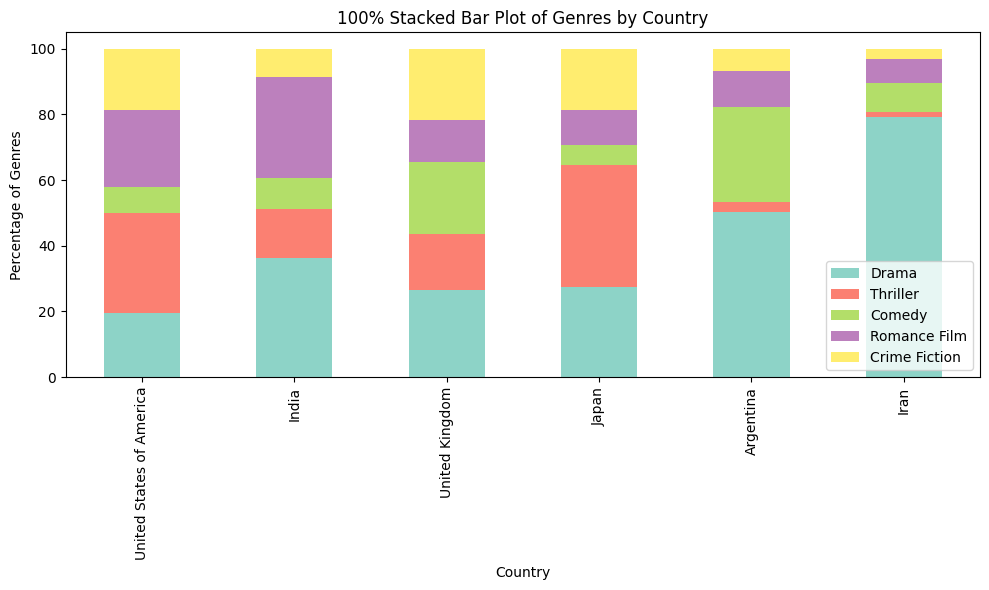

In [33]:
array_tot = []
for i in range(len(focus_countries)):
    v = [focus_countries[i]] + genres_data_by_country[i].values.tolist()
    array_tot.append(v)

df_tot = pd.DataFrame(array_tot, columns=['Countries'] + focus_genres)

df_normalized = df_tot.set_index('Countries')
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100

ax = df_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Genres')
ax.set_title('100% Stacked Bar Plot of Genres by Country')

plt.tight_layout()
plt.show()

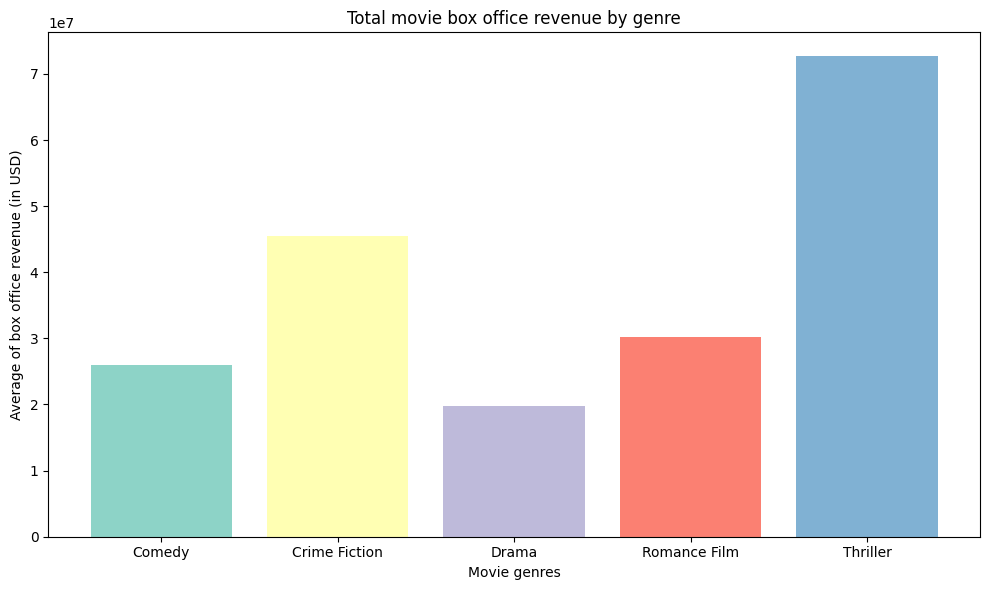

In [34]:
by_genres_stats = df_date_revenue_clean.groupby('Movie genres')['Movie box office revenue'].agg('mean').reset_index()
by_genres_stats.columns = ['Movie genres', 'Average revenue']

filtered_genres_stats = by_genres_stats[by_genres_stats['Movie genres'].isin(focus_genres)]

# Keep the same color as above 
colormap = matplotlib.colormaps['Set3']
colors = [colormap(i) for i in range(len(focus_genres))]

plt.figure(figsize=(10, 6))
plt.bar(filtered_genres_stats['Movie genres'], filtered_genres_stats['Average revenue'], color=colors)
plt.xlabel('Movie genres')
plt.ylabel('Average of box office revenue (in USD)')
plt.title('Total movie box office revenue by genre')
plt.tight_layout()
plt.show()

The genre with the highest average of box office revenue is Thriller. Japan and USA are producing a lot of Thriller movies. However Drama is the genre with the lowest average of box office revenue. Iran and Argentina are producing mainly Drama movies. India produces almost the same amount of Drama and Romance movies but both are not genres with a high average of box office revenue. UK is the only country with a quite proportional repartition between genres with almost the same amount of movies produced for every genre. 

Note : Thriller is the genre with the highest average of box office revenue. But is it because USA produces a lot of Thriller movies ? We know that USA are the country with the highest average of box office revenue so maybe Thriller is the genre with the highest average of box office revenue because it is a genre that USA produces a lot. 

# Actor gender

In this part we analyse the repartition of the gender in movie industry in the 6 countries we are focusing on.

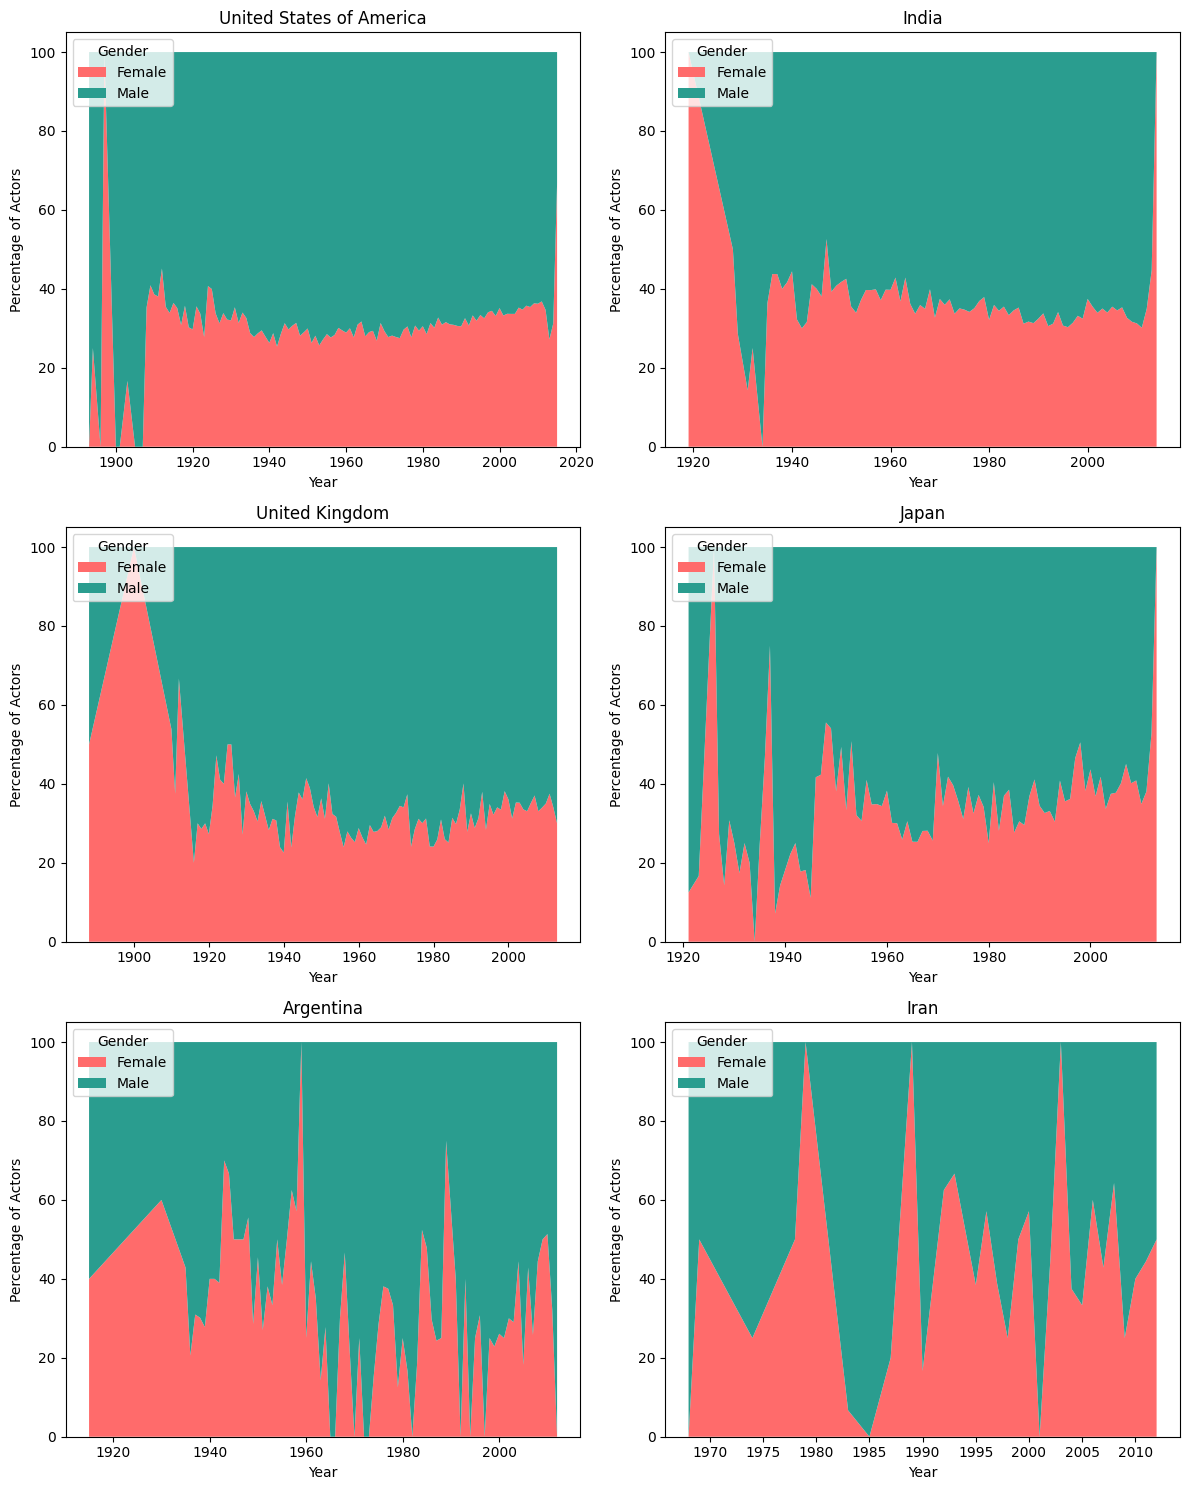

In [35]:
merged_df_focus = merged_df[merged_df['Movie country'].isin(focus_countries)]
actor_counts = merged_df_focus.groupby(['Movie release date', 'Movie country', 'Actor gender']).size().reset_index(name='Count')
total_counts = actor_counts.groupby(['Movie release date', 'Movie country'])['Count'].transform('sum')
actor_counts['Percentage'] = (actor_counts['Count'] / total_counts) * 100

actor_counts['Movie release date'] = pd.to_datetime(actor_counts['Movie release date'], errors='coerce')


num_rows, num_columns = 3, 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()  

for i, country in enumerate(focus_countries):
    ax = axes[i]
    country_data = actor_counts[actor_counts['Movie country'] == country]  # Filter data for the country
    
    # Pivot data for stackplot: years as x, male/female percentages as y
    pivot_data = country_data.pivot(index='Movie release date', columns='Actor gender', values='Percentage').fillna(0)
    years = pivot_data.index
    male_percentage = pivot_data.get('M', 0)
    female_percentage = pivot_data.get('F', 0)
    
    ax.stackplot(years, female_percentage, male_percentage, labels=['Female', 'Male'], colors=["#FF6B6B", "#2A9D8F"])
    
    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Actors')
    ax.legend(loc='upper left', title='Gender')

plt.tight_layout()
plt.show()


Concerning the USA, India, the UK and Japan we notice that the gender distribution is in favor of males, with on average 60% of actors and 40% of actresses in the movies throughout the years. Since 1940, the distribution did not really change, we observe a plateau in the curve of those 4 countries, the ratio is staying approximetaly the same. No countries put real efforts in establishing gender euquality in their movie industry. Concerning Argentina and Iran, the results are oscillating a lot, we cannot observe any trend. We think that there are not enough data to draw conclusions.

In [36]:
merged_df_revenue_clean = merged_df.dropna(axis=0)

In [37]:
movie_groups = merged_df_revenue_clean.groupby('Movie name')


movies =[]
box_offices=[]
def male_female_ratio(group):

    box_office = group[1]['Movie box office revenue'].mean()
    male_count = (group[1]['Actor gender'] == 'M').sum()
    female_count = (group[1]['Actor gender'] == 'F').sum()
    ratio = male_count / female_count if female_count > 0 else float('inf')
    return ratio, group[0], box_office

ratios = []
for group in movie_groups:
    ratio = male_female_ratio(group)[0]
    ratios.append(ratio)
    movies.append(male_female_ratio(group)[1])
    box_offices.append(male_female_ratio(group)[2])



ratio_per_movie = pd.DataFrame({
    'Movies': movies,
    'Ratios': ratios,
    'Box offices': box_offices
})



In [38]:
ratio_per_movie = ratio_per_movie[~ratio_per_movie.isin([np.inf, -np.inf]).any(axis=1)]

stats.pearsonr(ratio_per_movie['Ratios'],ratio_per_movie['Box offices'])

PearsonRResult(statistic=0.24849363640474495, pvalue=1.317094203242338e-57)

The Pvalue is really small which means that there is a significant correlation between the success of a movie and the ratio of male/female actors

In [39]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = ratio_per_movie['Ratios'].values.reshape(-1, 1)
y = ratio_per_movie['Box offices']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression().fit(X_poly, y)


optimal_ratio = -model.coef_[1] / (2 * model.coef_[2])
print(f"Optimal Ratio: {optimal_ratio}")



Optimal Ratio: 10.479601496507279


Once we knew that the correlation was significant we tried te find the optimal ratio for success. We performed a linear regression of degree 2, found the value of x corresponding to df/dx = 0. It corresponds to -b/2a. In the case of the curve of box office revenues in terms of ratios the value of x = 10,47.

To maximise the chance to produce a blockbuster, the number of actors should be 10 times higher than the number of actresses.

# Latent Dirichlet Allocation (LDA) for thematic analysis

To select only words that we judge meaningfull to define a movie topic, we use the Stanford CoreNLP-Processed Summaries (628 MB), which are plot summaries processed for linguistic analysis (tagging, parsing, named entity recognition, coreference).
From these, we filter:
- Common nouns, verbs, and adjectives
- Exclude a manually curated list of weak verbs

The LDA code, which takes around 2 hours to run, is in the separate notebook LDA.ipynb in order to make the result.ipynb notebook clear and concise. Here, we only import the pre-generated plots in .png format.

In [40]:
root = r"docs/assets/graphs/"


## General LDA analysis
We start by applying LDA to look at movies in a broad, general way, analyzing topics across all given plots.

LDA requires tuning of the number of topics to achieve the best results. To determine the optimal number, we evaluate models with different topic counts and select the one that produces the most coherent topics: coherence measures the semantic similarity between a topic’s key words, ensuring the identified themes make sense to a human reader and accurately reflect the dataset.

To get an initial idea of the optimal number of topics, we plot the coherence score as a function of the number of topics, ranging from 2 to 28 topics with a step of 5:

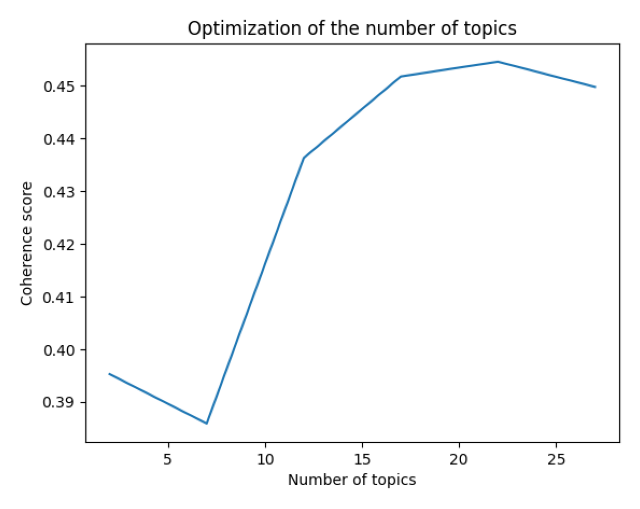

In [41]:
path = f"{root}OptimisationGeneral2_25.png"
img = mpimg.imread(path)
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

We observe that as the number of topics increases, the coherence score improves consistently until it peaks at 22 topics. This makes sense: with more topics, the model becomes more specific, breaking down broader themes into smaller, more distinct pieces, resulting in higher coherence scores.

However, a more coherent model isn’t always the most practical. Choosing too many topics can lead to overly specific results that are harder to interpret. A model with 22 topics does achieve higher coherence scores, but it becomes less useful for comparisons and fails to effectively capture broader themes.

To strike a balance, let’s focus on finding the most coherent model within the range of 2 to 5 topics. This will give us themes that are specific enough to be meaningful but broad enough for clear interpretation.

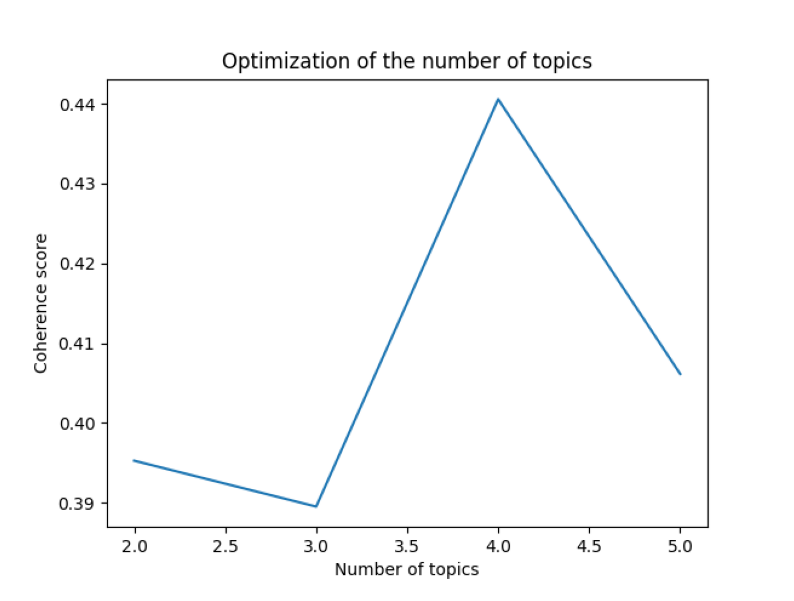

In [42]:
path = f"{root}OptimisationGeneral2_5.png"
img = mpimg.imread(path)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

4 topics is the perfect compromise between interpretability and coherence of the LDA model.

To better understand each topic, we examined the top 10 most representative words associated with it. These words give us a clear sense of the recurring ideas within each theme. Additionally, we identified the movie most strongly associated with each topic, providing a concrete example of how the theme is reflected in cinema.
Here’s what we found:

- "father", “family", "love", "son", "child", "mother", "marry", "young", "daughter", Best representative movie: Henry VIII
- "friend", "love", "money", "home", "time", "father", "school", "mother", "return", Best representative movie: Main Aur Mrs Khanna
- "police", "house", "car", "shoot", "head", "murder", "escape", "body", "night”, Best representative movie: Film, weird name right? Well it is indeed an American short film published in 1965 by Samuel Beckett: [Film - 1965 - Samuel Beckett](https://www.youtube.com/watch?v=BSnv6haPadM)
- "escape", "attack", "ship", "group", "order",, "force", "destroy", "fight", “soldier”, Best representative movie: Stargate

The four topics can be characterized as follows:

- Topic 0:  Family and Love
- Topic 1:  Relationships and Home Life
- Topic 2:  Crime and Thriller
- Topic 3:  Action and Adventure

These topics are a simplification of the LDA results, based on the most representative words and movies. This interpretation is inherently subjective, as each topic is a mix of ideas that cannot be fully captured by a single label, but it highly simplify our analysis so let’s make this simplification!

We can now compare the repartition of topics between the focus countries:

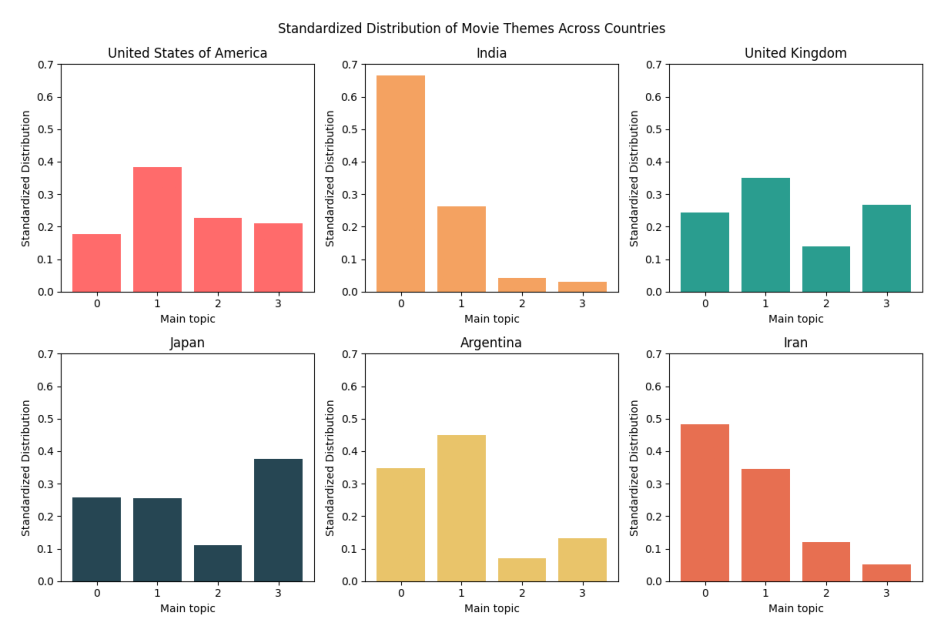

In [43]:
path = f"{root}Standardized_Distribution_Movie.png"
img = mpimg.imread(path)
plt.figure(figsize=(16, 8)) 
plt.imshow(img)
plt.axis('off')  


plt.show()

The graph shows clear cultural differences in movie themes across six countries. Family and Love (Topic 0) are prominent in India, Iran, and Argentina, reflecting a strong focus on emotional and familial storytelling. The United States and United Kingdom show a more balanced mix, with an emphasis on Relationships and Home Life (Topic 1) alongside elements of thrillers and action. Japan, on the other hand, stands out with a higher representation of Action and Adventure (Topic 3), reflecting a preference for dynamic, group-driven narratives often seen in genres like anime and sci-fi.

## Genre specific LDA analysis

To ensure unbiased results, we need a large enough sample size. For this, we focus on the movie genres in our dataset that contain more than 1,000 entries each:

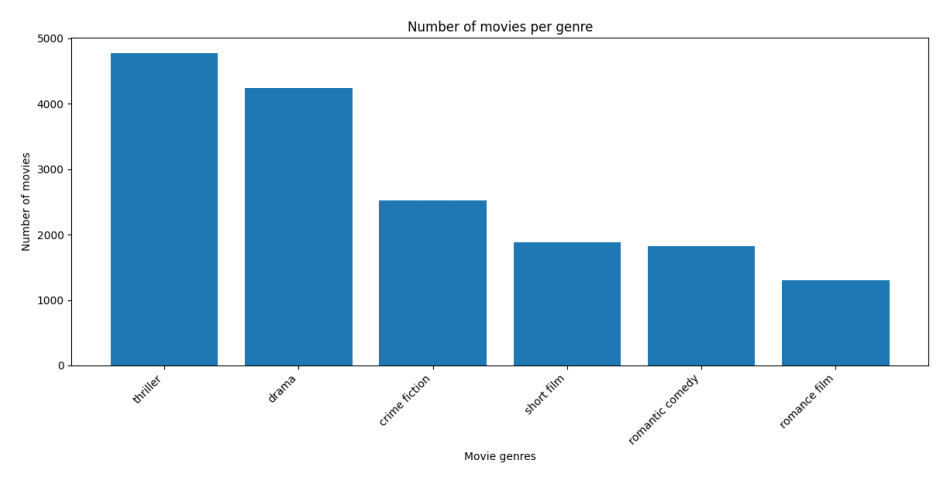

In [44]:

path = f"{root}Number_movies_per_genre.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()


We can see that we can obtain a large corpus by merging the genres: 'romantic comedy' and 'romance film' into a new genre that we call 'romance'

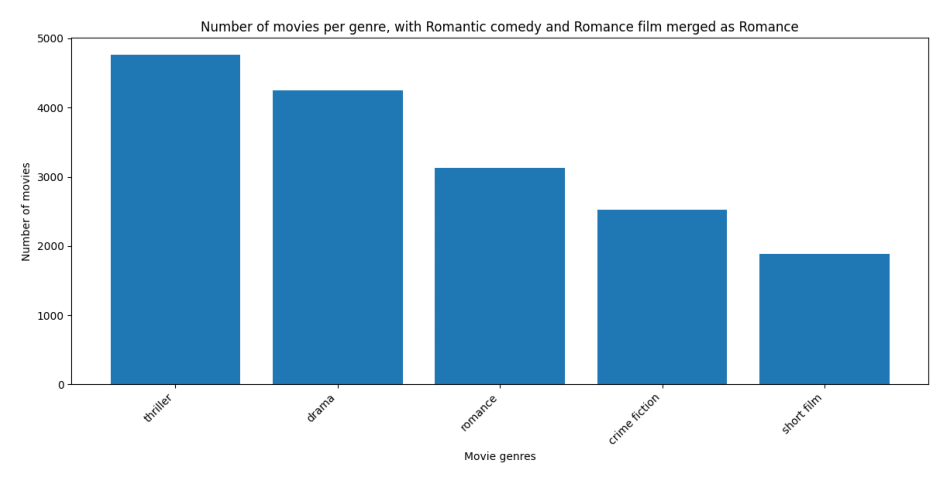

In [45]:

path = f"{root}Number_movies_per_genre_romancemerge.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()


From this, we focus on the Thriller, Drama, and Romance genres.

We apply the same method used in the General LDA to select the optimal number of topics for each genre, plotting the coherence score as a function of the number of topics

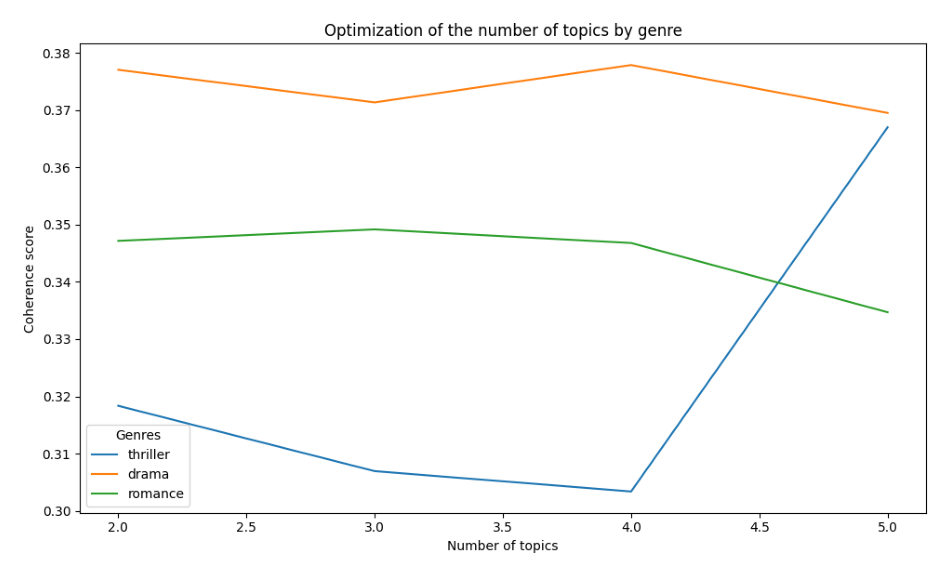

In [46]:
path = f"{root}OptimisationGenre.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

For Romance, the coherence score peaks at 3 topics before declining. In the case of Thriller, the score initially decreases but rises sharply at 5 topics. Finally for Drama, the score reaches its highest point at 4 topics before dropping, making 4 the optimal choice.

### **For the Thrillers:**

The identified topics are:

- "attack", "car", "body", “house", "room", "group", "head", "attempt", "dead", "die”
    
    Best representative movie: White Of The Eye
    
- "woman", "apartment", "killer", "case”, "room", "wife", "house", "home", "night", "shoot”
    
    Best representative movie: ...And Justice for All
    
- "order", "agent", "attempt", "attack", "force", "bomb", "group", "destroy", "team", "mission”
    
    Best representative movie: Ghosts of Mars
    
- "shoot", "car", "money", "gang", "gun", "officer", "head", "drug", "steal", "attempt”
    
    Best representative movie: Perrier's Bounty
    
- "father", "house", "mother", "family", “love", "wife", "home", "child", "son", "young”
    
    Best representative movie: Midnight Express
    

And with a bit of interpretation, we find that:

- Topic 0 focuses on violent incidents like *attacks*, *bodies*, and *attempts*.
- Topic 1 revolves around domestic settings and criminal investigations, with terms like *woman*, *apartment*, and *killer*.
- Topic 2 emphasizes organized operations, including *agents*, *attacks*, and *missions*.
- Topic 3 highlights themes of crime and gang activities, involving *shootings*, *money*, and *drugs*.
- Topic 4 centers on familial relationships, with words like *father*, *mother*, and *family*.

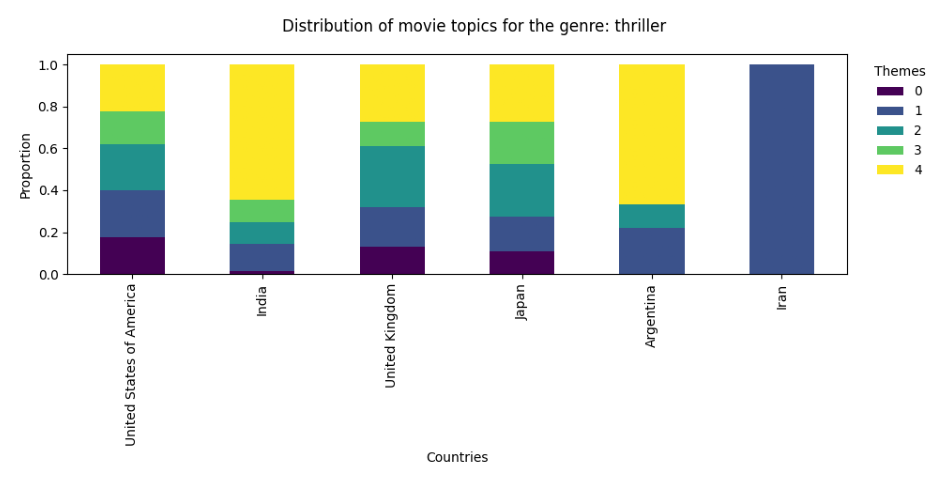

In [47]:
path = f"{root}thriller_topic_distribution.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

From the graph, Topic 4 is dominant in the United States, India, and Argentina, showing a preference for family-oriented thrillers. Topic 1 (domestic crime) is notably prevalent in Iran, where it accounts for the entire distribution, suggesting a focus on intimate and home-based thrillers. Topics 2 and 3, which include action-packed thrillers with elements of crime and missions, are more balanced across Japan and the United Kingdom, reflecting a diverse range of thriller subgenres in these regions. Meanwhile, Topic 0 has a moderate presence in all countries but does not dominate any specific one. This distribution highlights cultural preferences in thriller movies, with some countries leaning more toward family-centric plots, while others emphasize action, crime, or organized operations.

### For the Dramas movies:

- "love", "family", "marry", "father", "mother", "child", "son", "daughter", "friend", "man”
    
    Best representative movie: A Woman in Flames
    
- "man", "village", "son", "return", "family", "father", "story", "wife", "local", "young”
    
    Best representative movie: Karayilekku Oru Kadal Dooram
    
- "school", "friend", "boy", "mother", "time", "girl", "man", "child", "story", "home”
    
    Best representative movie: The High Cost of Living
    
- "father", "man", "home", "mother", "return", "time", "love", "friend", "woman", "wife”
    
    Best representative movie: The Great New Wonderful
    

which gives: 

- Topic 0 centers on familial relationships and love, with keywords like *love*, *family*, *father*, and *mother*.
- Topic 1 highlights village life and family dynamics, with words like *village*, *return*, and *story*.
- Topic 2 focuses on school life, friendships, and childhood experiences, featuring words such as *school*, *friend*, *boy*, and *mother*.
- Topic 3 blends family, love, and home-related themes with terms like *father*, *mother*, *home*, and *return*.

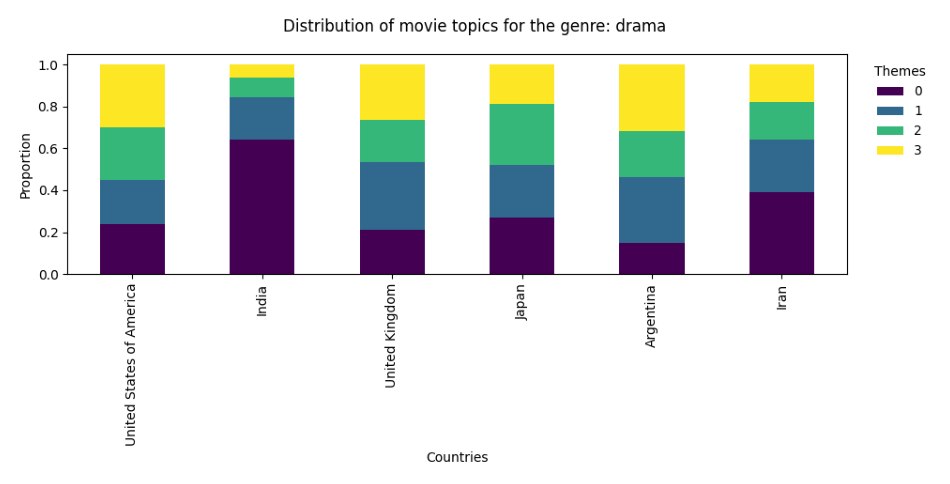

In [48]:
path = f"{root}drama_topic_distribution.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

From the graph, Topic 3 dominates in most countries, particularly in the United States, Argentina, and Japan, reflecting a global emphasis on familial and home-centered stories in drama films. Topic 0 (family and love) is prominent in India and Iran, where it accounts for a significant proportion of the drama themes, underscoring the cultural importance of family and relationships in storytelling. Topic 1 (village and family life) appears primarily in India and Japan, showcasing a regional focus on rural and local narratives. Meanwhile, Topic 2 (school and friendships) is present but less dominant overall, with noticeable representation in the United Kingdom and Argentina.

### For the Romance movies:

- "return", "money", "job", "woman", "home", "wife", "father", "night", "way", "husband”
    
    Best representative movie: Black Cat, White Cat
    
- "father", "family", "mother", "relationship", "school", "home", "parent", "house", "date", "wedding”
    
    Best representative movie: Little city
    
- "woman", "girl", "father", "daughter", "son", "story", "marriage", "family", "wife", "young”
    
    Best representative movie: Anbu Thozhi
    

which gives: 

- Topic 0 focuses on themes involving *return*, *money*, *job*, *woman*, *home*, and *husband*, suggesting narratives about work, relationships, and domestic challenges.
- Topic 1 centers on family and relationships, with words like *father*, *family*, *mother*, *relationship*, *school*, *home*, and *wedding*, highlighting family-oriented romance stories.
- Topic 2 emphasizes *woman*, *girl*, *father*, *daughter*, *marriage*, and *family*, which point to romantic stories featuring family dynamics, marriage, and young love.

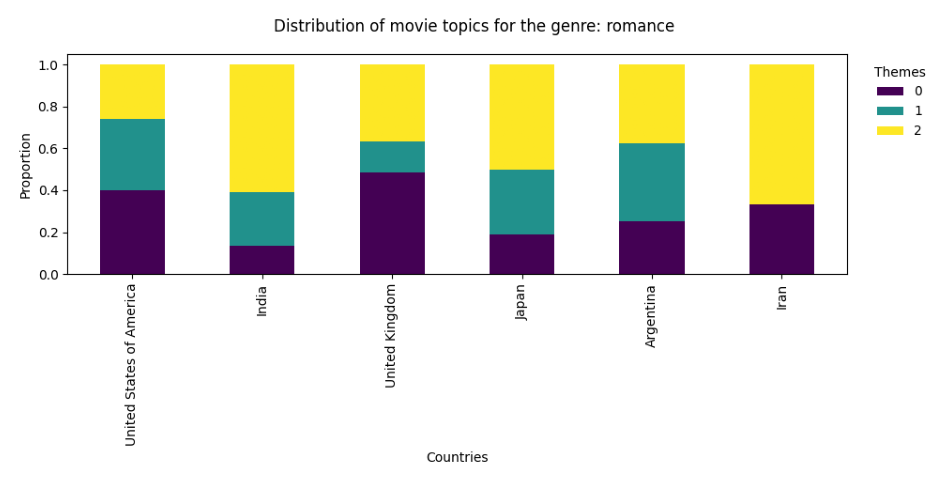

In [49]:
path = f"{root}romance_topic_distribution.png"
img = mpimg.imread(path)
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

From the graph, Topic 2 (marriage and family themes) is dominant across most countries, particularly in India, Iran, and Japan, reflecting a cultural focus on romantic relationships intertwined with family dynamics. In contrast, Topic 0 (work and domestic challenges) holds a stronger presence in the United States and United Kingdom, where more individual and relationship-driven narratives are prominent. Topic 1 (family and relationships) is notably significant in Argentina and Japan, indicating a balanced interest in family-centric romance.

### Summary of Genre Analysis
Overall, while themes of family and relationships are universal, countries like India, Iran, and Japan consistently prioritize familial and emotional ties across genres. Western countries such as the United States and United Kingdom incorporate a broader mix of themes, often blending individual struggles, domestic issues, and crime with family narratives. This reflects a cultural contrast between collective and individualistic storytelling approaches.